In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
import pickle

In [3]:
# Load data
df = pd.read_csv('../mentalhealth_dataset.csv')

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

print("\nBasic info:")
print(df.info())

print("\nMissing values:")
print(df.isnull().sum())

print("\nDescriptive statistics:")
print(df.describe())

Dataset shape: (1000, 16)

Columns: ['Timestamp', 'Gender', 'Age', 'Course', 'YearOfStudy', 'CGPA', 'Depression', 'Anxiety', 'PanicAttack', 'SpecialistTreatment', 'SymptomFrequency_Last7Days', 'HasMentalHealthSupport', 'SleepQuality', 'StudyStressLevel', 'StudyHoursPerWeek', 'AcademicEngagement']

First few rows:
   Timestamp  Gender  Age         Course YearOfStudy  CGPA  Depression  \
0  13/7/2020  Female   24  Biotechnology      Year 3  2.38           1   
1  13/7/2020  Female   18  Biotechnology      Year 3  4.00           0   
2  13/7/2020  Female   25  Biotechnology      Year 3  3.68           0   
3  13/7/2020  Female   18    Engineering      year 4  4.00           0   
4  13/7/2020  Female   20    Engineering      year 4  2.00           1   

   Anxiety  PanicAttack  SpecialistTreatment  SymptomFrequency_Last7Days  \
0        0            0                    0                           5   
1        1            0                    0                           0   
2        0  

In [4]:
# Data cleaning
# Handle inconsistent YearOfStudy values
df['YearOfStudy'] = df['YearOfStudy'].str.replace('year', 'Year', case=False).str.strip()

In [5]:
# Create target variable - any mental health issue
df['MentalHealthIssue'] = (df['Depression'] | df['Anxiety'] | df['PanicAttack']).astype(int)

In [6]:
print("\nMental Health Issue Distribution:")
print(df['MentalHealthIssue'].value_counts(normalize=True))


Mental Health Issue Distribution:
MentalHealthIssue
1    0.845
0    0.155
Name: proportion, dtype: float64


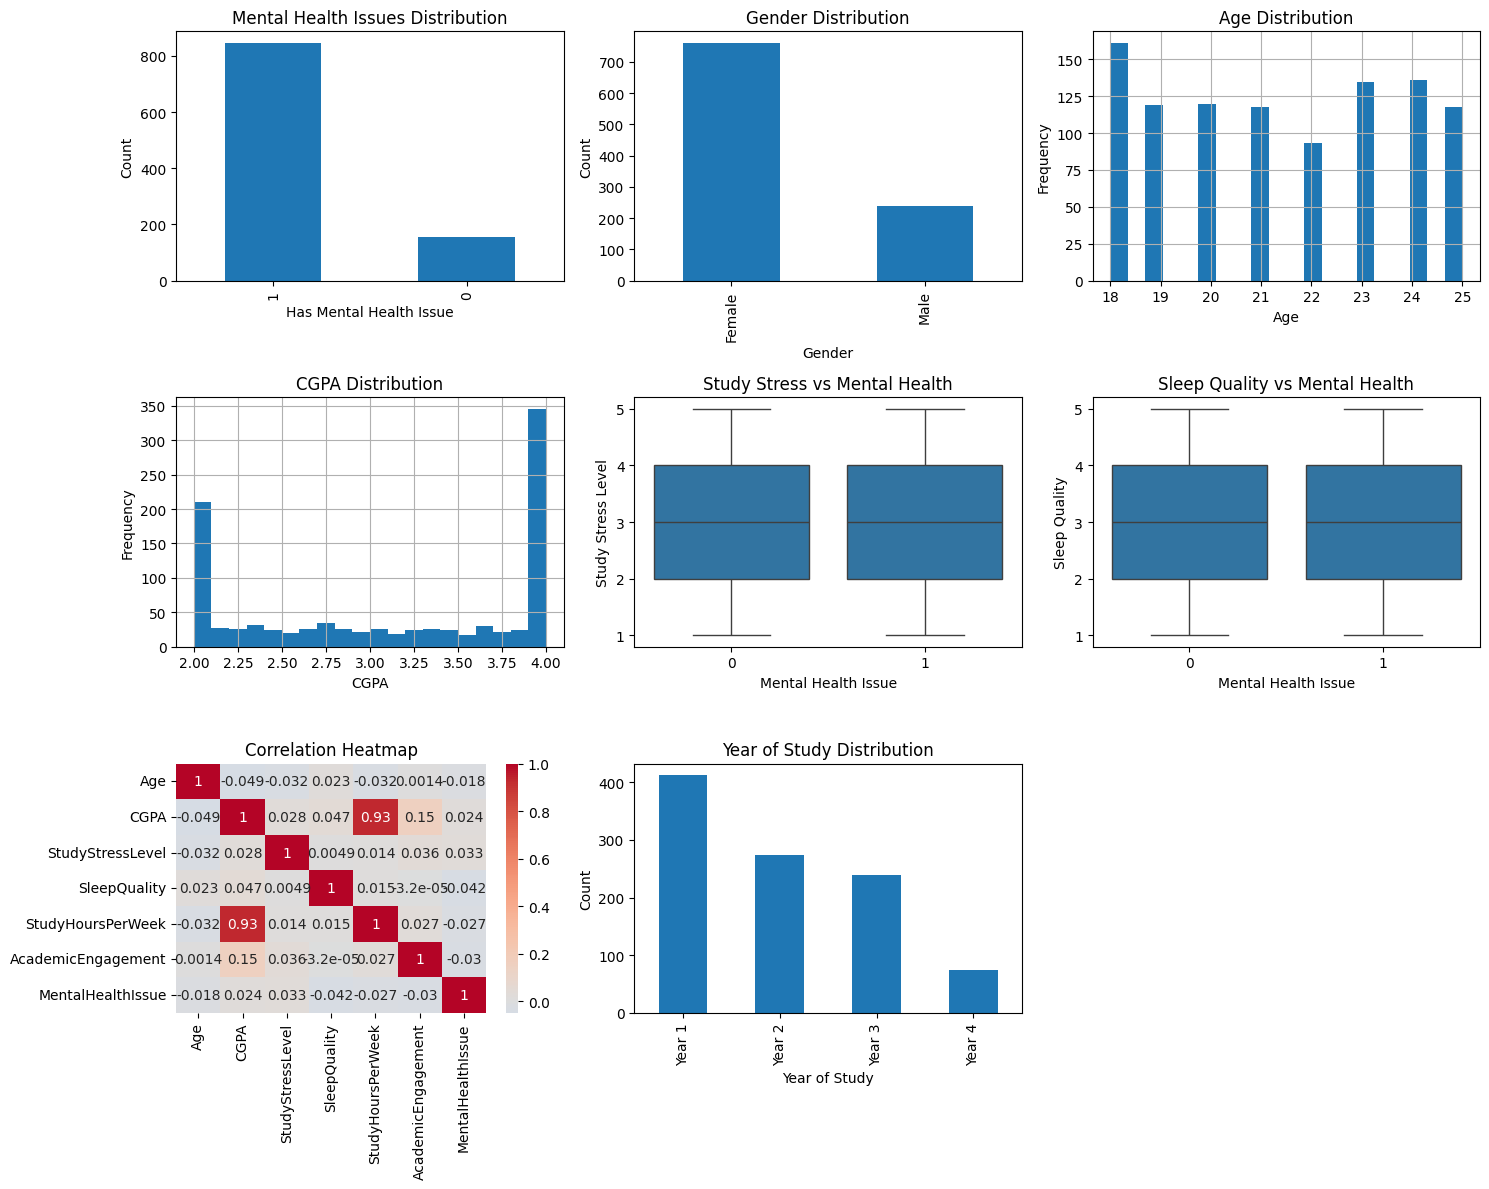

In [8]:
# Exploratory Data Analysis
plt.figure(figsize=(15, 12))

# 1. Mental health distribution
plt.subplot(3, 3, 1)
df['MentalHealthIssue'].value_counts().plot(kind='bar')
plt.title('Mental Health Issues Distribution')
plt.xlabel('Has Mental Health Issue')
plt.ylabel('Count')

# 2. Gender distribution
plt.subplot(3, 3, 2)
df['Gender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

# 3. Age distribution
plt.subplot(3, 3, 3)
df['Age'].hist(bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# 4. CGPA distribution
plt.subplot(3, 3, 4)
df['CGPA'].hist(bins=20)
plt.title('CGPA Distribution')
plt.xlabel('CGPA')
plt.ylabel('Frequency')

# 5. Study stress vs mental health
plt.subplot(3, 3, 5)
sns.boxplot(x='MentalHealthIssue', y='StudyStressLevel', data=df)
plt.title('Study Stress vs Mental Health')
plt.xlabel('Mental Health Issue')
plt.ylabel('Study Stress Level')

# 6. Sleep quality vs mental health
plt.subplot(3, 3, 6)
sns.boxplot(x='MentalHealthIssue', y='SleepQuality', data=df)
plt.title('Sleep Quality vs Mental Health')
plt.xlabel('Mental Health Issue')
plt.ylabel('Sleep Quality')

# 7. Correlation heatmap
plt.subplot(3, 3, 7)
numeric_cols = ['Age', 'CGPA', 'StudyStressLevel', 'SleepQuality', 'StudyHoursPerWeek', 'AcademicEngagement']
correlation_matrix = df[numeric_cols + ['MentalHealthIssue']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')

# 8. Year of study distribution
plt.subplot(3, 3, 8)
df['YearOfStudy'].value_counts().plot(kind='bar')
plt.title('Year of Study Distribution')
plt.xlabel('Year of Study')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [9]:
# Feature importance analysis
X = df.drop(['MentalHealthIssue', 'Depression', 'Anxiety', 'PanicAttack', 'Timestamp'], axis=1, errors='ignore')
y = df['MentalHealthIssue']

# Preprocessing
categorical_features = ['Gender', 'Course', 'YearOfStudy']
numeric_features = ['Age', 'CGPA', 'StudyStressLevel', 'SleepQuality', 'StudyHoursPerWeek', 
                   'AcademicEngagement', 'SymptomFrequency_Last7Days']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

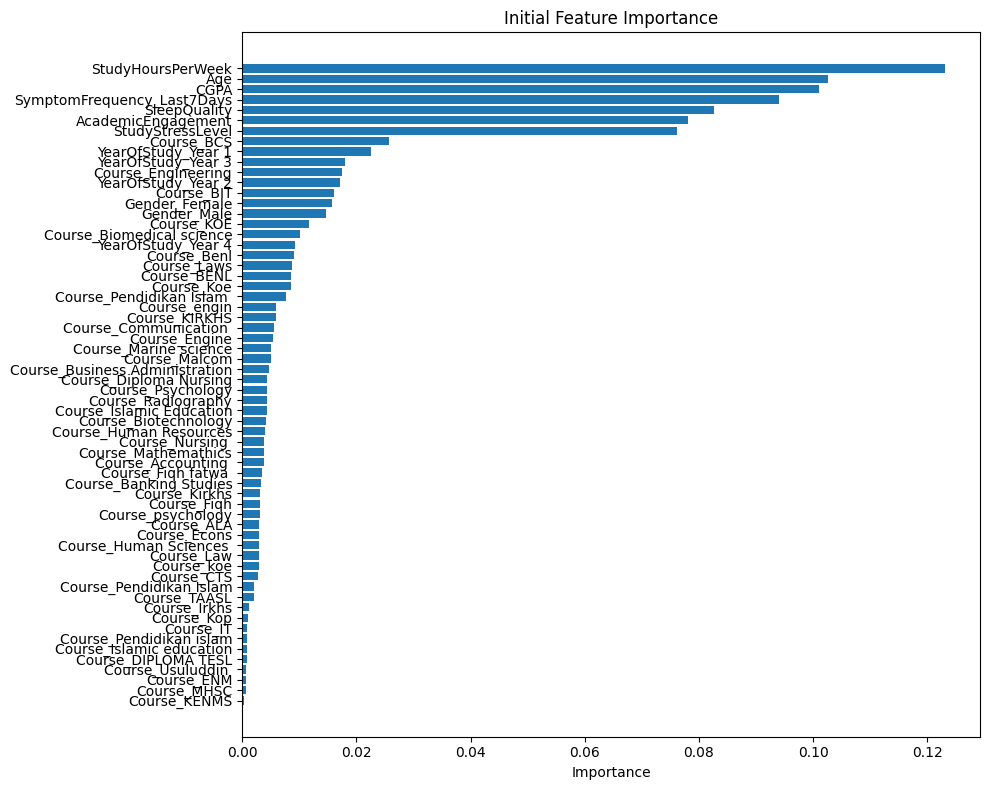

Top 10 most important features:
                       feature  importance
60          YearOfStudy_Year 3    0.018098
58          YearOfStudy_Year 1    0.022490
11                  Course_BCS    0.025639
2             StudyStressLevel    0.076184
5           AcademicEngagement    0.078115
3                 SleepQuality    0.082624
6   SymptomFrequency_Last7Days    0.094095
1                         CGPA    0.100966
0                          Age    0.102525
4            StudyHoursPerWeek    0.123065


In [10]:
# Quick Random Forest to check feature importance
X_processed = preprocessor.fit_transform(X)
feature_names = (numeric_features + 
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

rf_initial = RandomForestClassifier(n_estimators=100, random_state=42)
rf_initial.fit(X_processed, y)

plt.figure(figsize=(10, 8))
feature_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_initial.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_imp['feature'], feature_imp['importance'])
plt.title('Initial Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Top 10 most important features:")
print(feature_imp.tail(10))